In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.integrate import quad, trapezoid

In [197]:
def signal(t, A, tau, alpha):
    if 0 <= t <= tau:
        return A * t * np.exp(-alpha * t)
    else:
        return 0.0

In [198]:
def integrand_real(t, A, tau, alpha, omega):
    return signal(t, A, tau, alpha) * np.cos(omega * t)

In [199]:
def integrand_imag(t, A, tau, alpha, omega):
    return -signal(t, A, tau, alpha) * np.sin(omega * t)

In [200]:
def fourier_transform(omega, A, tau, alpha):
    real_part, _ = quad(integrand_real, 0, tau, args=(A, tau, alpha, omega,))
    imag_part, _ = quad(integrand_imag, 0, tau, args=(A, tau, alpha, omega,))
    return real_part + 1j * imag_part

In [201]:
def plot_amplitude_spectrum(omega, F_omegas, colors , taus):
    plt.figure(figsize=(12, 8))

    for ind in range(len(F_omegas)):
        plt.plot(omega, np.abs(F_omegas[ind]), label=f'Amplitude spectrum tau = {taus[ind]}', color=colors[ind])
    
    plt.ylabel('|F(ω)|')
    plt.grid(True)
    plt.legend()
    plt.show()

In [202]:
def plot_phase_spectrum(omega, F_omegas, colors, taus):
    plt.figure(figsize=(12, 8))

    for ind in range(len(F_omegas)):
        plt.plot(omega, np.angle(F_omegas[ind]), label=f'Phase spectrum tau = {taus[ind]}', color=colors[ind])
        
    plt.xlabel('ω')
    plt.ylabel('∠F(ω) [rad]')
    plt.grid(True)
    plt.legend()
    plt.show()

In [203]:
A = 1.0
taus = [1.0, 2.0, 3.0]
alpha = 1.0
omega = np.linspace(-8, 8, 1000)
colors = ['r', 'g', 'b']

F_omegas = [np.array([fourier_transform(w, A, tau, alpha) for w in omega]) for tau in taus]

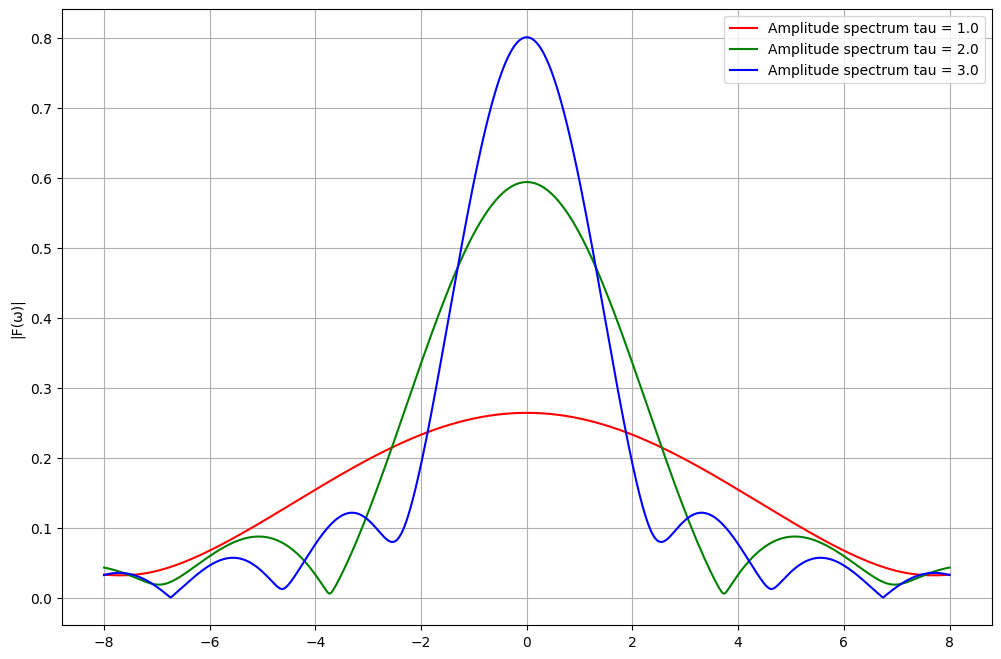

In [204]:
plot_amplitude_spectrum(omega=omega, F_omegas=F_omegas, colors=colors, taus=taus)

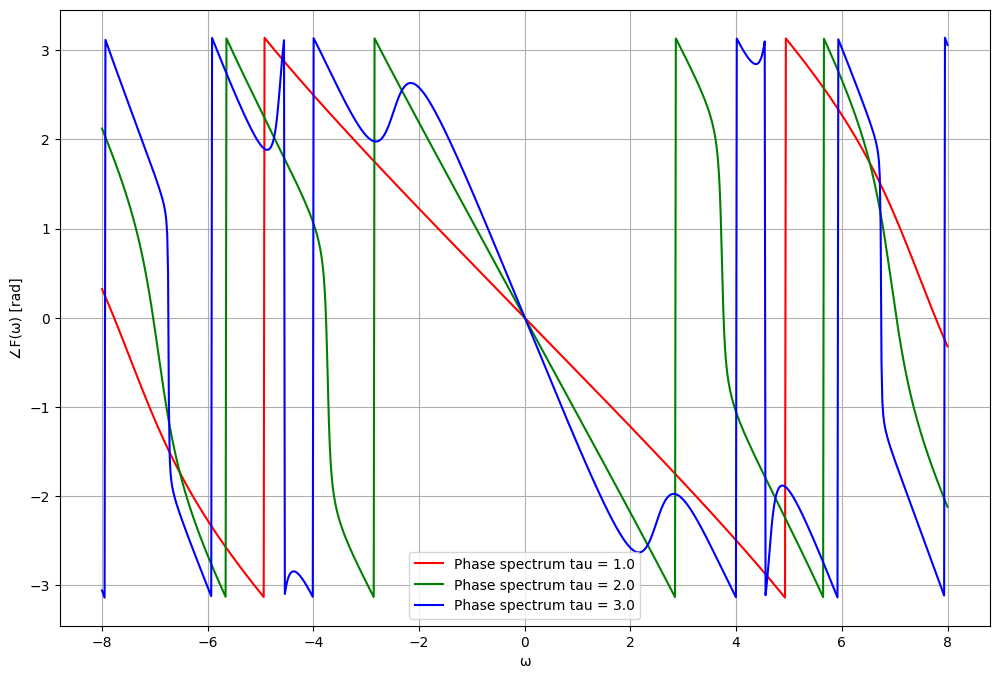

In [205]:
plot_phase_spectrum(omega=omega, F_omegas=F_omegas, colors=colors, taus=taus)

In [206]:
def inverse_fourier_transform(t, spectrum, omega_values, d_omega):
    integral = 0
    for i, omega in enumerate(omega_values):
        integral += spectrum[i] * np.exp(1j * omega * t) * d_omega
    return integral.real / (2 * np.pi)

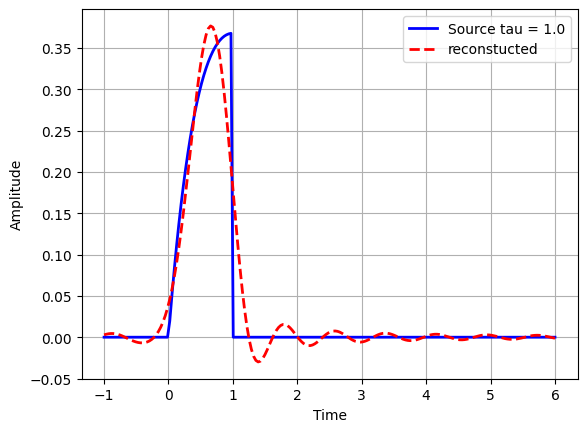

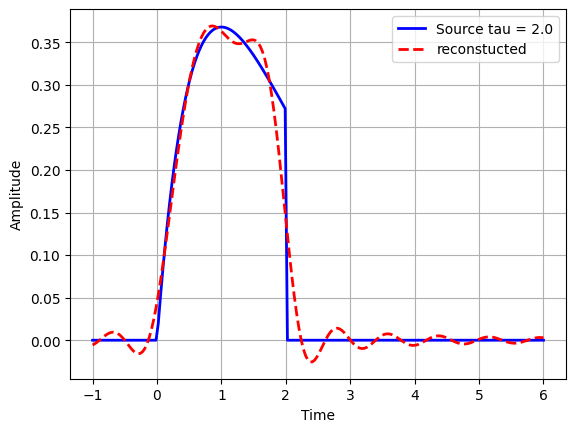

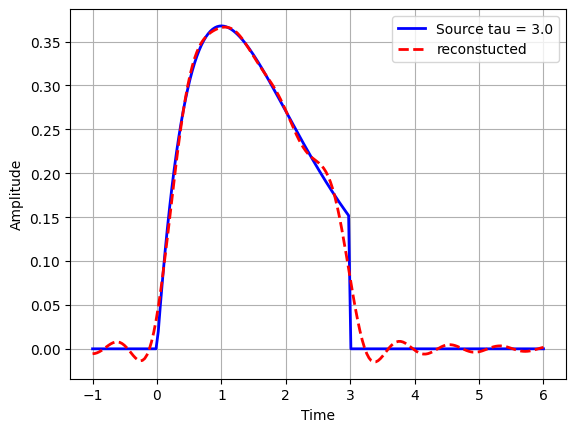

In [207]:
d_omega = omega[1] - omega[0]
t_values = np.linspace(-1, taus[0]+5, 200)

for ind in range(len(taus)):
    reconstructed = np.array([inverse_fourier_transform(t, F_omegas[ind], omega, d_omega) for t in t_values])
    original = np.array([signal(t, A, taus[ind], alpha) for t in t_values])

    plt.plot(t_values, original, 'b-', linewidth=2, label=f'Source tau = {taus[ind]}')
    plt.plot(t_values, reconstructed, 'r--', linewidth=2, label='reconstucted')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


In [208]:
def calculate_energy(signal, t_values):
    squared_signal = signal**2
    energy = trapezoid(squared_signal, t_values)
    return energy

In [209]:
energy_original = calculate_energy(original, t_values)
energy_reconstructed = calculate_energy(reconstructed, t_values)
energy_original.item(), energy_reconstructed.item()

(0.23434061581472318, 0.23340901041136325)

In [210]:
def f1(t):
    return 1.0 if 0 <= t <= 2 else 0.0

def f2(t):
    return np.cos(t) if 0 < t < 2*np.pi else 0.0

In [211]:
def cross_correlation(tau):
    lower_bound = max(0, -tau)
    upper_bound = min(2, 2*np.pi - tau)

    if lower_bound >= upper_bound:
        return 0.0
    
    result, _ = quad(lambda t: f1(t) * f2(t + tau), lower_bound, upper_bound)
    return result

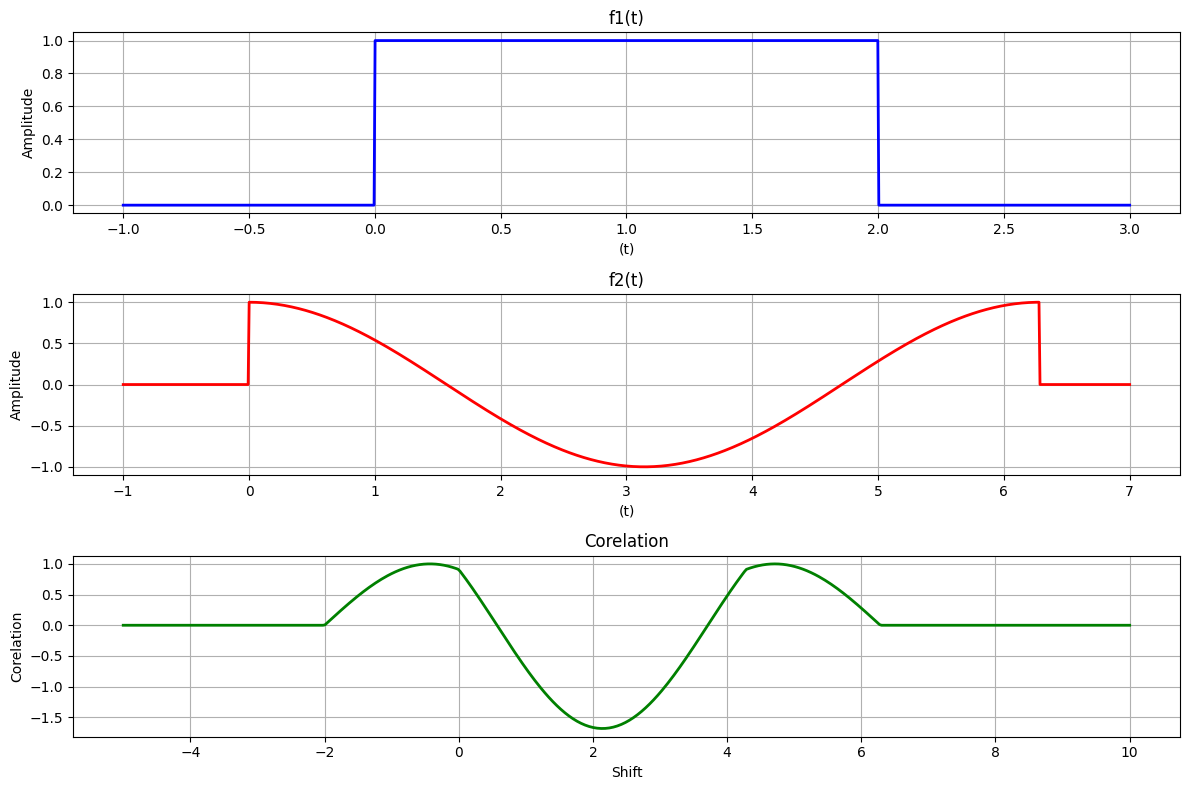

In [212]:
tau_values = np.linspace(-5, 10, 500)

correlation_values = [cross_correlation(tau) for tau in tau_values]

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
t_values1 = np.linspace(-1, 3, 1000)
f1_values = [f1(t) for t in t_values1]
plt.plot(t_values1, f1_values, 'b-', linewidth=2)
plt.title('f1(t)')
plt.xlabel('(t)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 2)
t_values2 = np.linspace(-1, 7, 1000)
f2_values = [f2(t) for t in t_values2]
plt.plot(t_values2, f2_values, 'r-', linewidth=2)
plt.title('f2(t)')
plt.xlabel('(t)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tau_values, correlation_values, 'g-', linewidth=2)
plt.title('Corelation')
plt.xlabel('Shift')
plt.ylabel('Corelation')
plt.grid(True)

plt.tight_layout()
plt.show()

max_corr = max(correlation_values)
max_index = np.argmax(correlation_values)
max_tau = tau_values[max_index]


In [213]:
def signal(t, tau):
    return A / np.sqrt(1 + np.cosh(t/tau)**2)

In [214]:
def calculate_effective_duration(tau, t_max=1.0, num_points=10000):
    t_values = np.linspace(-t_max, t_max, num_points)    
    signal_values = signal(t_values, tau)    
    energy = np.trapezoid(signal_values**2, t_values)    
    t_center = np.trapezoid(t_values * signal_values**2, t_values) / energy
    t2_moment = np.trapezoid((t_values - t_center)**2 * signal_values**2, t_values) / energy
    effective_duration = np.sqrt(t2_moment)
    
    return effective_duration

In [215]:
A = 1.0
tau1 = 0.15
tau2 = 0.285

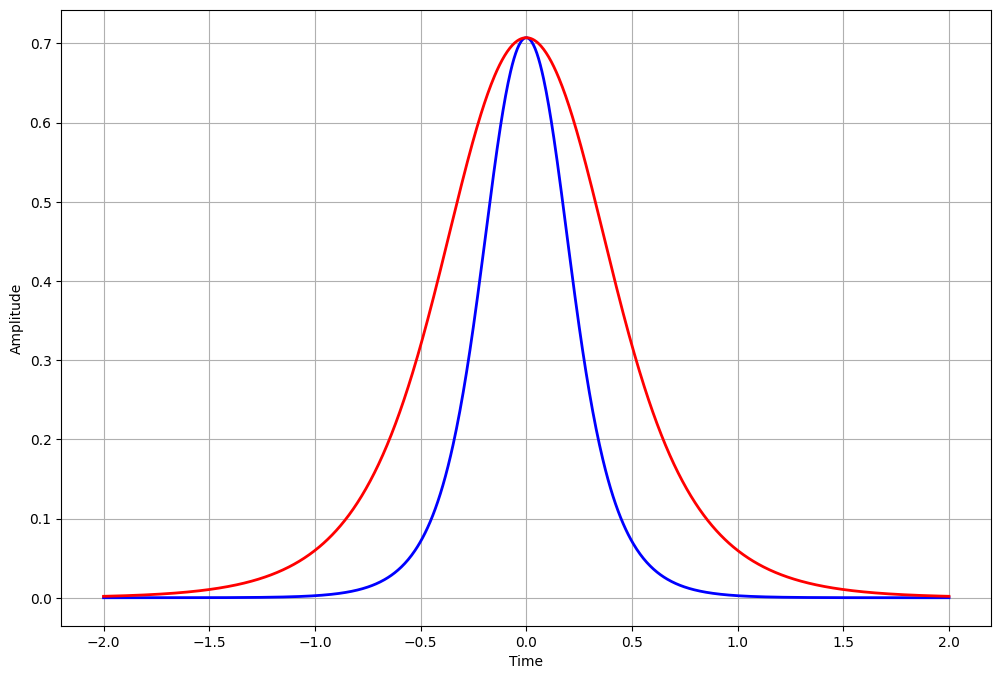

In [216]:
t_values = np.linspace(-2, 2, 1000)
signal_values1 = signal(t_values, tau1)
signal_values2 = signal(t_values, tau2)

plt.figure(figsize=(12, 8))
plt.plot(t_values, signal_values1, 'b-', linewidth=2, label=f"tau={tau1}")
plt.plot(t_values, signal_values2, 'r-', linewidth=2, label=f"tau={tau2}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)

plt.show()

eff_duration1 = calculate_effective_duration(tau1)
eff_duration2 = calculate_effective_duration(tau2)

# print(f"Для τ = {tau1}: эффективная длительность = {eff_duration1:.6f}")
# print(f"Для τ = {tau2}: эффективная длительность = {eff_duration2:.6f}")

In [217]:
def compute_spectrum(tau, t_max=5.0, n_points=2**14):
    t = np.linspace(-t_max, t_max, n_points)
    dt = t[1] - t[0]
    
    s = signal(t, tau)
    
    spectrum = fft(s)
    frequencies = fftfreq(n_points, dt)
    
    frequencies = fftshift(frequencies)
    spectrum = fftshift(spectrum)
    
    return frequencies, spectrum

In [218]:
freq1, spec1 = compute_spectrum(tau1)
freq2, spec2 = compute_spectrum(tau2)

amp_spec1 = np.abs(spec1)
amp_spec2 = np.abs(spec2)

norm_amp_spec1 = amp_spec1 / np.max(amp_spec1)
norm_amp_spec2 = amp_spec2 / np.max(amp_spec2)

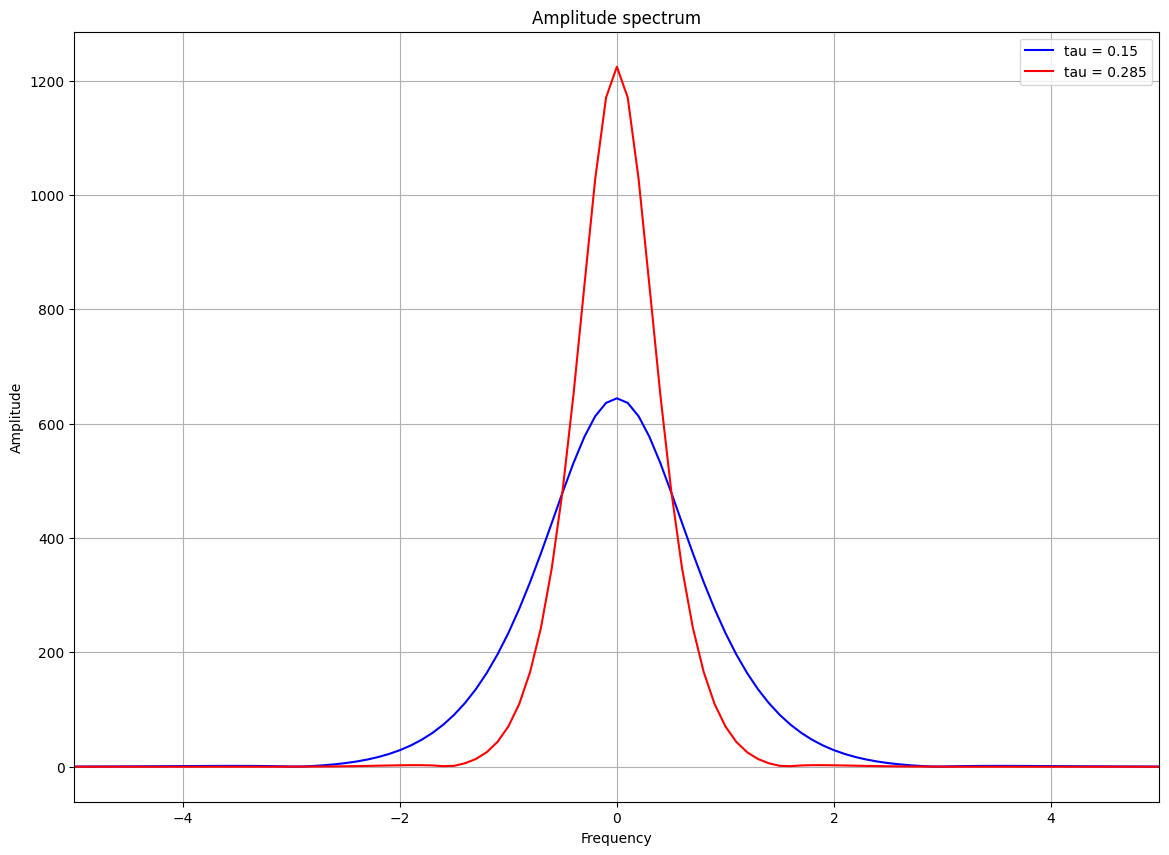

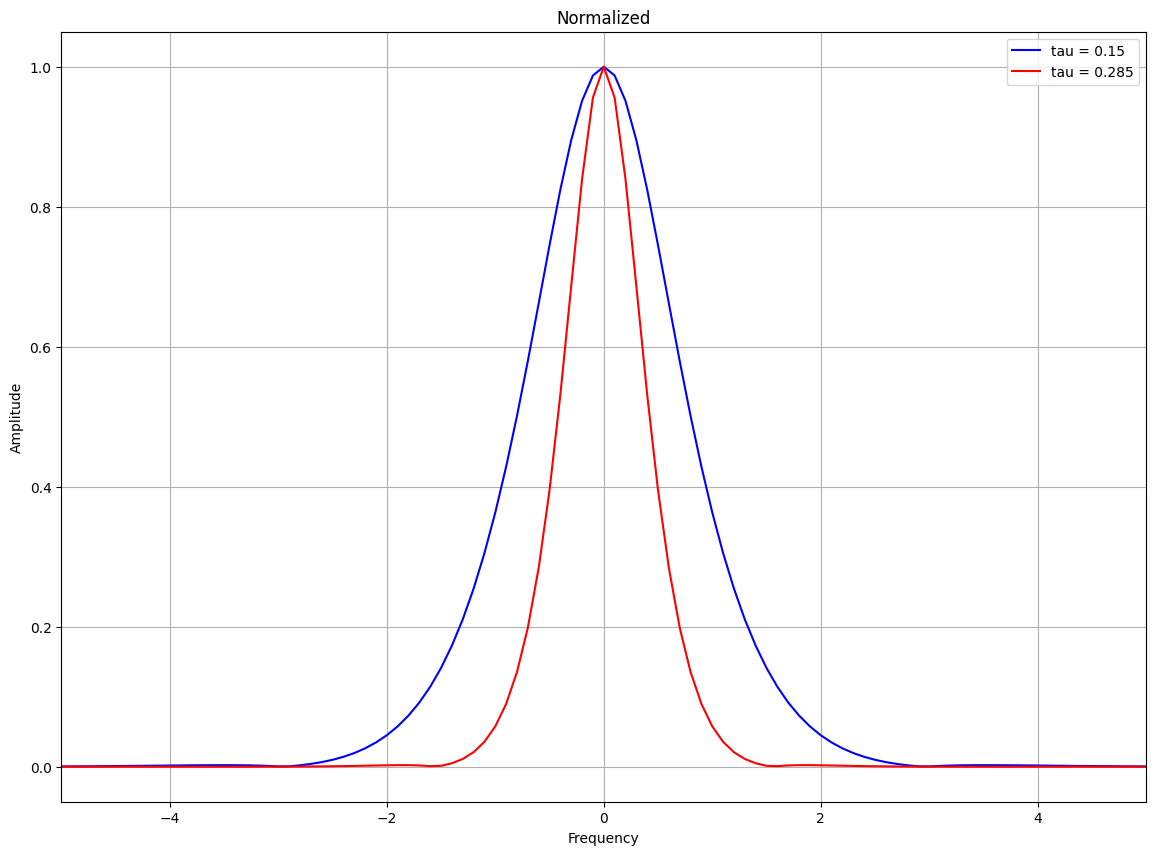

In [219]:
plt.figure(figsize=(14, 10))

plt.plot(freq1, amp_spec1, 'b-', linewidth=1.5, label=f"tau = {tau1}")
plt.plot(freq2, amp_spec2, 'r-', linewidth=1.5, label=f"tau = {tau2}")
plt.title(f'Amplitude spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.xlim(-5, 5)
plt.show()


plt.figure(figsize=(14, 10))

plt.plot(freq1, norm_amp_spec1, 'b-', linewidth=1.5, label=f"tau = {tau1}")
plt.plot(freq2, norm_amp_spec2, 'r-', linewidth=1.5, label=f"tau = {tau2}")
plt.title('Normalized')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.xlim(-5, 5)
plt.show()

In [220]:
durations = [0.212, 0.403]
bandwidths = [23.5, 12.4]

In [221]:
def delayed_signal(t, tau, delay):
    return signal(t - delay, tau)

In [222]:

def compute_spectrum(tau, delay, t_max=5.0, n_points=2**14):
    t = np.linspace(-t_max, t_max, n_points)
    dt = t[1] - t[0]
    
    original = signal(t, tau)
    delayed = delayed_signal(t, tau, delay)
    
    spectrum_original = fft(original)
    spectrum_delayed = fft(delayed)
    
    frequencies = fftfreq(n_points, dt)
    
    frequencies = fftshift(frequencies)
    spectrum_original = fftshift(spectrum_original)
    spectrum_delayed = fftshift(spectrum_delayed)
    
    return frequencies, spectrum_original, spectrum_delayed

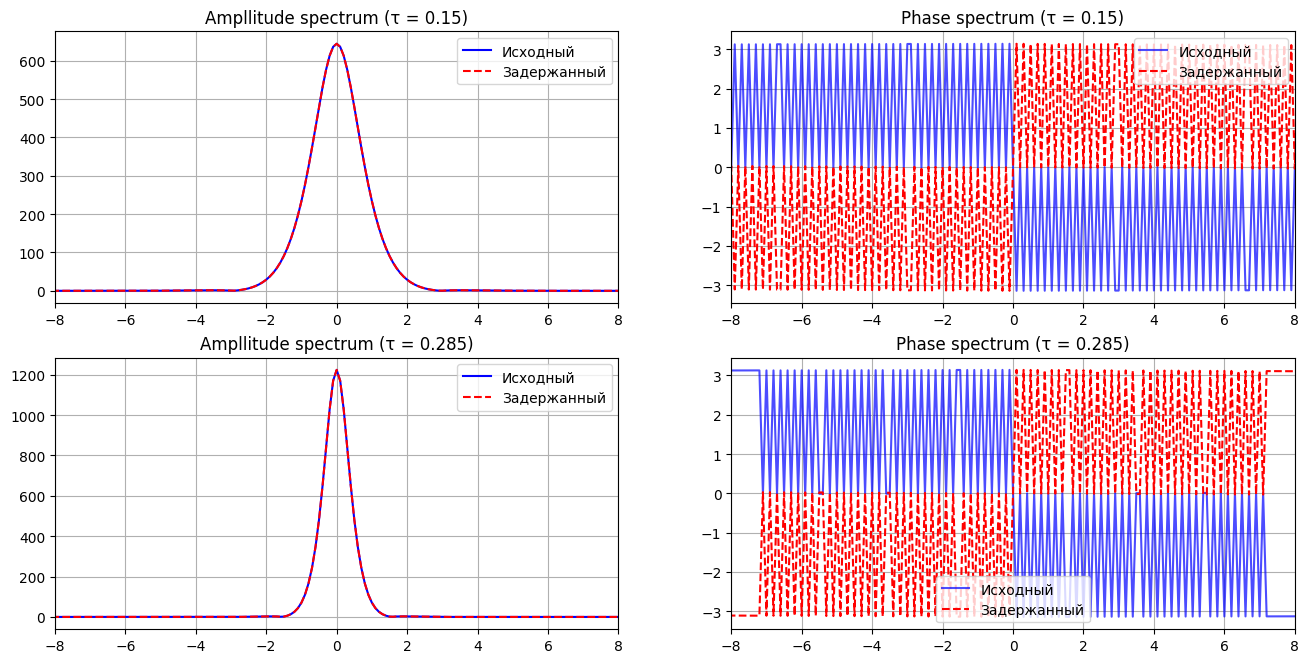

In [223]:
delay = 0.001

freq1, spec_orig1, spec_del1 = compute_spectrum(tau1, delay)
freq2, spec_orig2, spec_del2 = compute_spectrum(tau2, delay)

amp_orig1 = np.abs(spec_orig1)
phase_orig1 = np.angle(spec_orig1)

amp_orig2 = np.abs(spec_orig2)
phase_orig2 = np.angle(spec_orig2)

amp_del1 = np.abs(spec_del1)
phase_del1 = np.angle(spec_del1)

amp_del2 = np.abs(spec_del2)
phase_del2 = np.angle(spec_del2)

plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(freq1, amp_orig1, 'b-', linewidth=1.5, label='Исходный')
plt.plot(freq1, amp_del1, 'r--', linewidth=1.5, label='Задержанный')
plt.title(f'Ampllitude spectrum (τ = {tau1})')
plt.legend()
plt.grid(True)
plt.xlim(-8, 8)

plt.subplot(3, 2, 2)
plt.plot(freq1, phase_orig1, 'b-', linewidth=1.5, label='Исходный', alpha=0.7)
plt.plot(freq1, phase_del1, 'r--', linewidth=1.5, label='Задержанный')
plt.title(f'Phase spectrum (τ = {tau1})')
plt.legend()
plt.grid(True)
plt.xlim(-8, 8)

plt.subplot(3, 2, 3)
plt.plot(freq2, amp_orig2, 'b-', linewidth=1.5, label='Исходный')
plt.plot(freq2, amp_del2, 'r--', linewidth=1.5, label='Задержанный')
plt.title(f'Ampllitude spectrum (τ = {tau2})')
plt.legend()
plt.grid(True)
plt.xlim(-8, 8)

plt.subplot(3, 2, 4)
plt.plot(freq2, phase_orig2, 'b-', linewidth=1.5, label='Исходный', alpha=0.7)
plt.plot(freq2, phase_del2, 'r--', linewidth=1.5, label='Задержанный')
plt.title(f'Phase spectrum (τ = {tau2})')
plt.legend()
plt.grid(True)
plt.xlim(-8, 8)
plt.show()

In [224]:
def scaled_signal(t, tau, a):
    return signal(a * t, tau)

In [225]:
def compute_spectrum(signal_func, tau, a, t_max=3.0, n_points=2**14):
    t = np.linspace(-t_max, t_max, n_points)
    dt = t[1] - t[0]
    
    signal_values = signal_func(t, tau, a)
    
    spectrum = fft(signal_values)
    frequencies = fftfreq(n_points, dt)
    
    frequencies = fftshift(frequencies)
    spectrum = fftshift(spectrum)
    
    return t, frequencies, spectrum

In [226]:
def theoretical_spectrum_scaling(omega, tau, a):    
    omega_scaled = omega / a
    return 1/np.abs(a) * np.exp(-np.abs(omega_scaled) * tau)

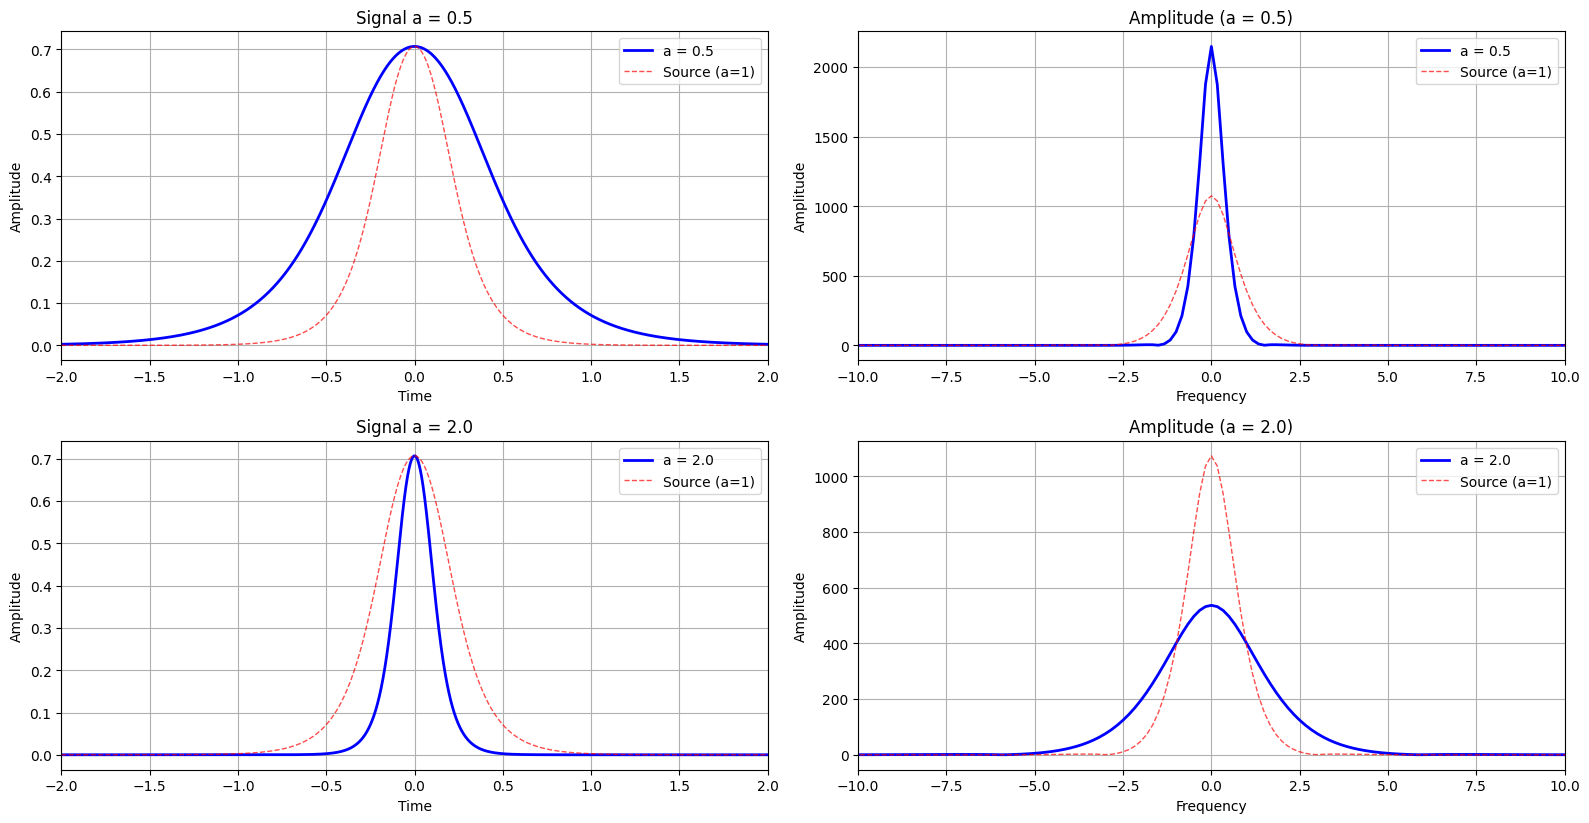

In [227]:
a_values = [0.5, 2.0]

results = {}
for a in a_values:
    t, frequencies, spectrum = compute_spectrum(scaled_signal, tau1, a)
    results[a] = {
        't': t,
        'frequencies': frequencies,
        'spectrum': spectrum,
        'amplitude': np.abs(spectrum),
        'phase': np.angle(spectrum)
    }

t_orig, freq_orig, spec_orig = compute_spectrum(lambda t, tau, a: signal(t, tau), tau1, 1)
amplitude_orig = np.abs(spec_orig)

plt.figure(figsize=(16, 12))

for i, a in enumerate(a_values):
    plt.subplot(3, 2, i*2 + 1)
    plt.plot(results[a]['t'], scaled_signal(results[a]['t'], tau1, a), 
             'b-', linewidth=2, label=f'a = {a}')
    plt.plot(t_orig, signal(t_orig, tau1), 'r--', linewidth=1, alpha=0.7, label='Source (a=1)')
    plt.title(f'Signal a = {a}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.xlim(-2, 2)

for i, a in enumerate(a_values):
    plt.subplot(3, 2, i*2 + 2)
    plt.plot(results[a]['frequencies'], results[a]['amplitude'], 
             'b-', linewidth=2, label=f'a = {a}')
    plt.plot(freq_orig, amplitude_orig, 'r--', linewidth=1, alpha=0.7, label='Source (a=1)')
    plt.title(f'Amplitude (a = {a})')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.xlim(-10, 10)

plt.tight_layout()
plt.show()

In [228]:
def differentiated_signal(t, tau):
    # f(t) = A / sqrt(1 + cosh²(t/τ))
    # f'(t) = -A * cosh(t/τ) * sinh(t/τ) / [τ * (1 + cosh²(t/τ))^(3/2)]
    cosh_val = np.cosh(t/tau)
    sinh_val = np.sinh(t/tau)
    denominator = tau * (1 + cosh_val**2)**(3/2)
    return -A * cosh_val * sinh_val / denominator

In [229]:
def compute_spectrum(t, signal):
    n_points = len(t)
    dt = t[1] - t[0]
    
    spectrum = fft(signal)
    frequencies = fftfreq(n_points, dt)
    
    frequencies = fftshift(frequencies)
    spectrum = fftshift(spectrum)
    
    return frequencies, spectrum

In [ ]:
def theoretical_spectrum_diff(omega, spectrum_original):
    # F{f'(t)} = jω * F{f(t)}
    return 1j * omega * spectrum_original

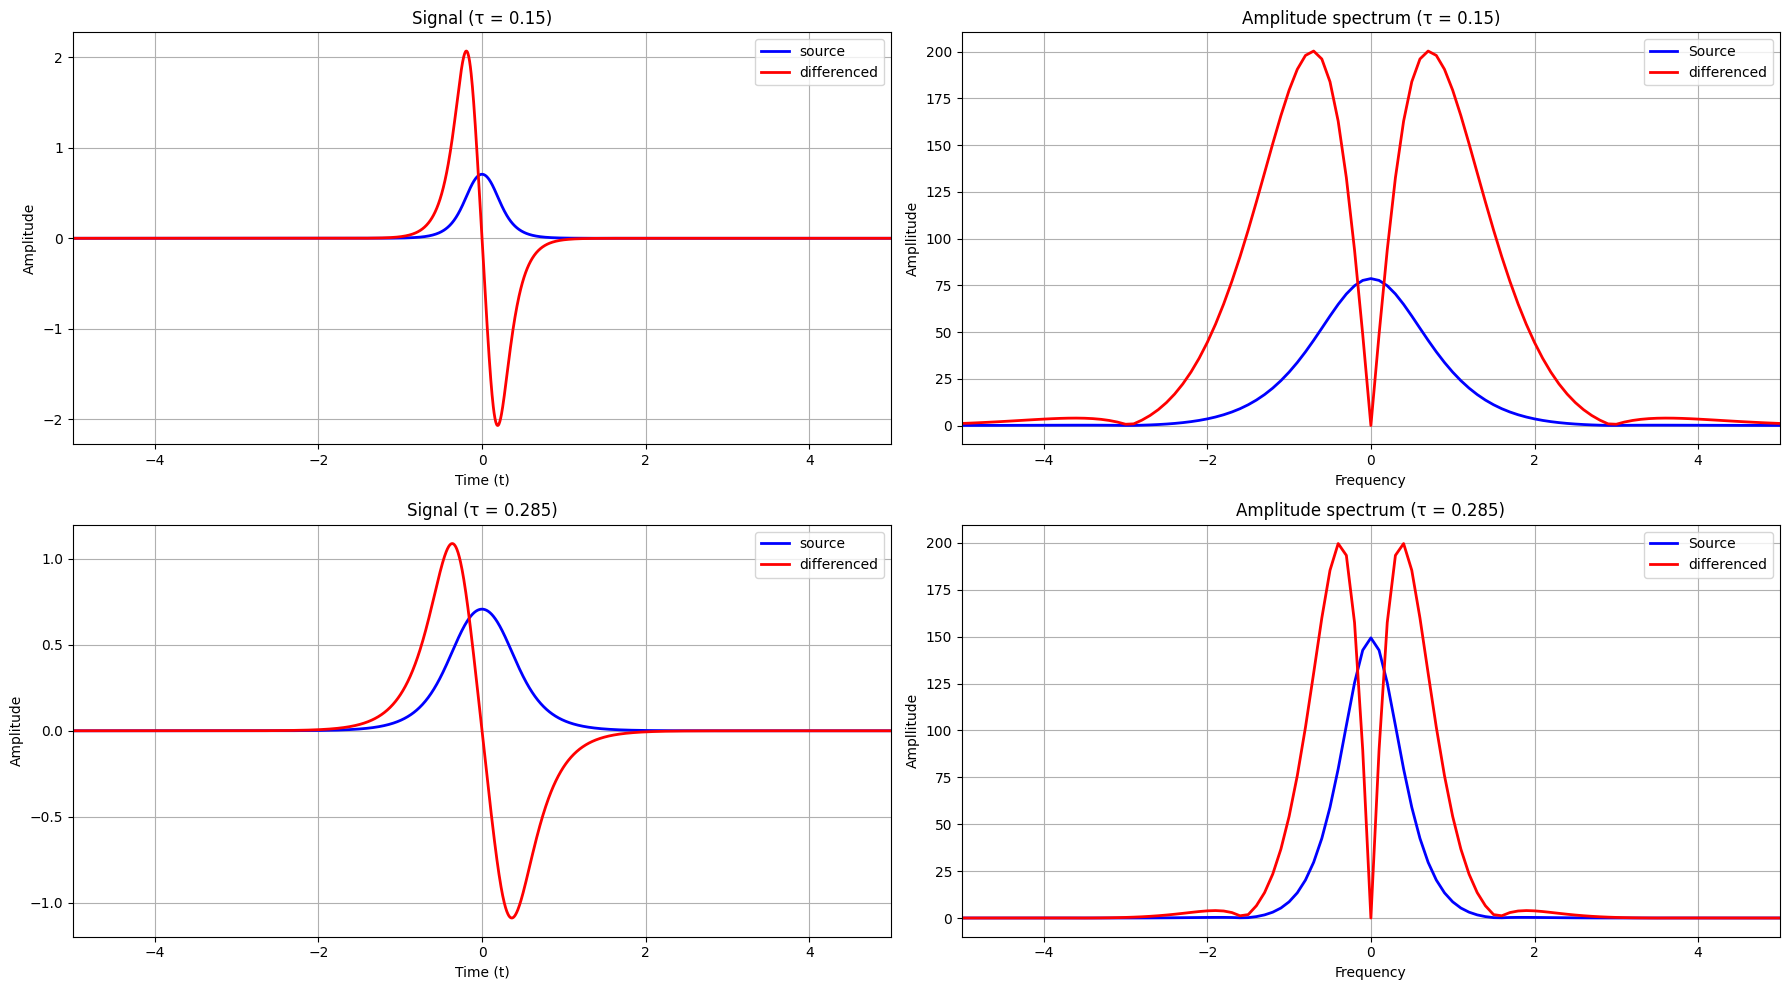

In [231]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
tau_values = [.15, .285]

for i, tau in enumerate(tau_values):
    t = np.linspace(-5, 5, 2000)
    
    original = signal(t, tau)
    diff = differentiated_signal(t, tau)
    
    ax1 = axes[i, 0]
    ax1.plot(t, original, 'b-', linewidth=2, label='source')
    ax1.plot(t, diff, 'r-', linewidth=2, label='differenced')
    ax1.set_title(f'Signal (τ = {tau})')
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(-5, 5)
    
    freq_orig, spec_orig = compute_spectrum(t, original)
    freq_diff, spec_diff = compute_spectrum(t, diff)
    
    amp_orig = np.abs(spec_orig)
    amp_diff = np.abs(spec_diff)
    
    ax2 = axes[i, 1]
    ax2.plot(freq_orig, amp_orig, 'b-', linewidth=2, label='Source')
    ax2.plot(freq_diff, amp_diff, 'r-', linewidth=2, label='differenced')
    ax2.set_title(f'Amplitude spectrum (τ = {tau})')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Ampllitude')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xlim(-5, 5)

plt.tight_layout()
plt.show()